In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

# Use functions I created to implement the LSTM neural network
from LSTM import splitting_to_tensor
from LSTM import splitting_tr_te
from LSTM import LSTM
from LSTM import train_LSTM

sns.set()

In [2]:
# Import all the portfolios to be used for model training
returns = pd.read_csv("../data/100portfolioReturns.csv", index_col=0)
returns = returns.dropna()
returns.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,return
2012-04-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-04-03 00:00:00,-0.007446,-0.005276,-0.003327,-0.003998,-0.004997,-0.002600,-0.004703,-0.006392,-0.002469,-0.008691,...,-0.001224,-0.001968,-0.006162,-0.002358,-0.003388,-0.004309,-0.009976,-0.003208,-0.005690,-0.003989
2012-04-04 00:00:00,-0.016311,-0.011805,-0.014316,-0.010425,-0.012191,-0.014013,-0.011545,-0.016360,-0.011443,-0.014566,...,-0.010765,-0.011257,-0.013789,-0.009558,-0.009170,-0.011063,-0.019043,-0.009759,-0.015222,-0.014150
2012-04-05 00:00:00,-0.019330,-0.014877,-0.012136,-0.013979,-0.011770,-0.011771,-0.010776,-0.018710,-0.013322,-0.014644,...,-0.007452,-0.011277,-0.014654,-0.010360,-0.010234,-0.009119,-0.020947,-0.006877,-0.015974,-0.014771
2012-04-09 00:00:00,-0.031573,-0.026465,-0.023117,-0.024117,-0.023724,-0.024937,-0.022501,-0.029633,-0.023794,-0.026331,...,-0.018200,-0.020261,-0.023815,-0.019523,-0.020336,-0.020080,-0.033850,-0.018209,-0.024500,-0.025961


In [3]:
# Split the returns into a train and test set
train_returns, test_returns = splitting_tr_te(returns)
# Split the training returns to train and validation sets to train the model and transform to a tensor. 
train_input, train_target, test_input, test_target = splitting_to_tensor(train_returns)

print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

torch.Size([98, 2263])
torch.Size([98, 2263])
torch.Size([3, 2263])
torch.Size([3, 2263])


In [4]:
# Set up the model, loss function, and optimizer
model = LSTM().float()
criterion = nn.MSELoss()
optimizer  = optim.LBFGS(model.parameters(), lr=0.6, max_iter=5)

# Train LSTM model
preds, loss = train_LSTM(train_input, train_target, test_input, test_target, model=model, criterion=criterion, optimizer=optimizer)

Step: 0
Loss: 1.254453182220459
Loss: 1.2210537195205688
Loss: 0.47710317373275757
Loss: 0.3930606544017792
Loss: 0.38767603039741516
Test Loss: 0.481679767370224
Step: 1
Loss: 0.3788747489452362
Loss: 0.3563939929008484
Loss: 0.3241373896598816
Loss: 0.2817855477333069
Loss: 0.5405580997467041
Test Loss: 0.10641443729400635
Step: 2
Loss: 0.1113889068365097
Loss: 0.0636507198214531
Loss: 0.0495246946811676
Loss: 0.045753635466098785
Loss: 0.04446636885404587
Test Loss: 0.04876289516687393
Step: 3
Loss: 0.043938521295785904
Loss: 0.0434349961578846
Loss: 0.04255672171711922
Loss: 0.04109717532992363
Loss: 0.03906755894422531
Test Loss: 0.04056577757000923
Step: 4
Loss: 0.03638380393385887
Loss: 0.03212674707174301
Loss: 0.030061347410082817
Loss: 0.029750723391771317
Loss: 0.029630690813064575
Test Loss: 0.03021497279405594
Step: 5
Loss: 0.029579026624560356
Loss: 0.029564253985881805
Loss: 0.029556989669799805
Loss: 0.029548324644565582
Loss: 0.029532574117183685
Test Loss: 0.030096553

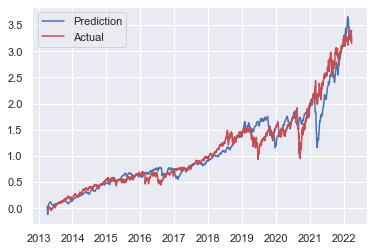

In [5]:
# Visualize how well the model performs on forecasting
dates = pd.to_datetime(returns.reset_index()["index"])

num = 1

plt.plot(dates[252:], preds[num], label="Prediction")
plt.plot(dates[252:], test_target[num], "r", label="Actual")
plt.legend()

plt.show()

Test Loss: 0.0380461888577562


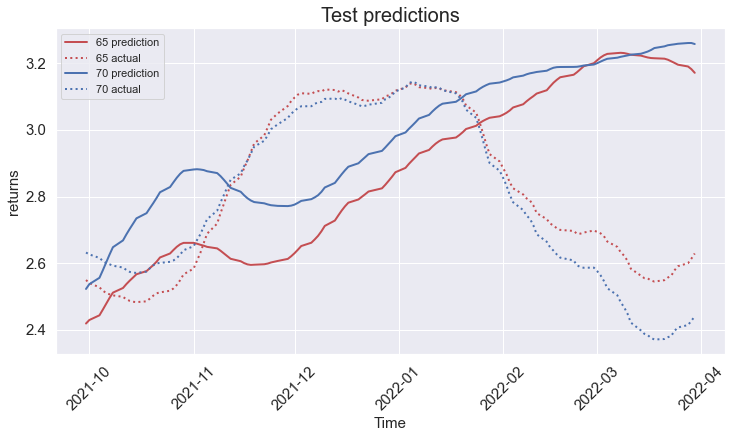

In [30]:
# Test the model on the full portfolio returns data and make predictions for certain portfolios

# Select portfolios to test the model on
testing = returns[["65", "70"]]

# Forecast 6 months into the future (126 trading days in 6 months)
future_preds = 126
transformed_testing = testing.T.to_numpy()
testing_input = torch.from_numpy(transformed_testing[:, :-future_preds])
testing_target = torch.from_numpy(transformed_testing[:, future_preds:])

# Run the data through the LSTM 
with torch.no_grad():
        pred = model(testing_input.float())
        loss = criterion(pred, testing_target)
        print("Test Loss:", loss.item())
        y = pred.detach().numpy()
        actuals = testing_target.detach().numpy()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.title(f"Test predictions", fontsize=20)
plt.xlabel("Time", fontsize=15)
plt.ylabel("returns", fontsize=15)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
n = testing_input.shape[1]
def draw(y_i, actuals, color, number):
        plt.plot(dates[-future_preds:], y_i[-future_preds:], color, linewidth=2.0, label=f"{testing.columns[number]} prediction")
        plt.plot(dates[-future_preds:], actuals[-future_preds:], color + ":", linewidth=2.0, label=f"{testing.columns[number]} actual")
draw(y[0], actuals[0], "r", number=0)
draw(y[1], actuals[1], "b", number=1)
plt.legend()

plt.show()

In [7]:
# Create a model to predict the betas

# Import and split data
beta = pd.read_csv("../data/100portfolioBetas.csv", index_col=0)
beta = beta.dropna()
train_beta, test_beta = splitting_tr_te(beta)
b_train_input, b_train_target, b_test_input, b_test_target = splitting_to_tensor(train_beta)

# Set model, loss function, and optimizer
b_model = LSTM().float()
b_criterion = nn.MSELoss()
b_optimizer  = optim.LBFGS(b_model.parameters(), lr=0.6, max_iter=5)

# Train the model
b_preds, b_loss = train_LSTM(b_train_input, b_train_target, b_test_input, b_test_target, model=b_model, criterion=b_criterion, optimizer=b_optimizer)

Step: 0
Loss: 1.3186180591583252
Loss: 1.2792108058929443
Loss: 0.11677920818328857
Loss: 0.05044059455394745
Loss: 0.05038011074066162
Test Loss: 0.01943887770175934
Step: 1
Loss: 0.04397902265191078
Loss: 0.040182340890169144
Loss: 0.0316832959651947
Loss: 0.015914343297481537
Loss: 0.010376643389463425
Test Loss: 0.008001923561096191
Step: 2
Loss: 0.010261749848723412
Loss: 0.010205231606960297
Loss: 0.010188648477196693
Loss: 0.010176162235438824
Loss: 0.010152949020266533
Test Loss: 0.008461623452603817
Step: 3
Loss: 0.010108262300491333
Loss: 0.010030299425125122
Loss: 0.00991034135222435
Loss: 0.009748844429850578
Loss: 0.009537909179925919
Test Loss: 0.008437472395598888
Step: 4
Loss: 0.009252666495740414
Loss: 0.009021991863846779
Loss: 0.008885519579052925
Loss: 0.008745896629989147
Loss: 0.008645529858767986
Test Loss: 0.0078074135817587376
Step: 5
Loss: 0.008540098555386066
Loss: 0.008480767719447613
Loss: 0.008428740315139294
Loss: 0.008391777984797955
Loss: 0.008364013396

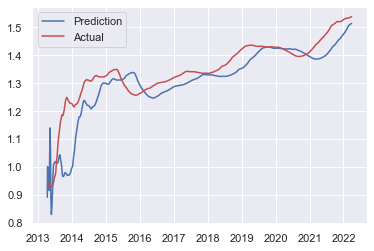

In [8]:
# Visualize how well the model performs on forecasting
dates = pd.to_datetime(beta.reset_index()["index"])

num = 1

plt.plot(dates[252:], b_preds[num], label="Prediction")
plt.plot(dates[252:], b_test_target[num], "r", label="Actual")
plt.legend()

plt.show()

Test Loss: 0.012685873889493068


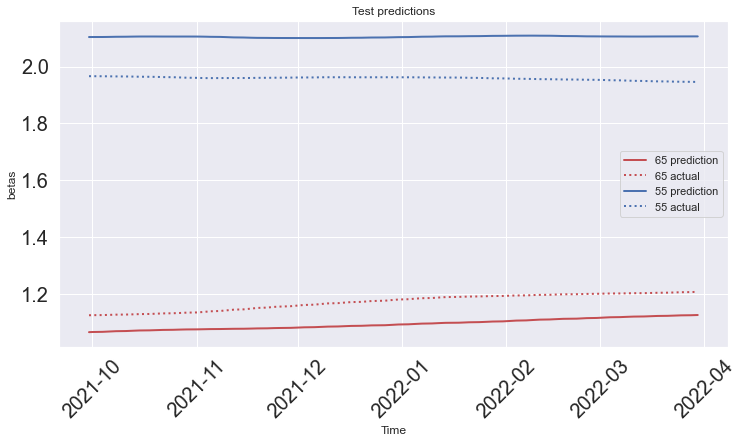

In [11]:
# Test the model on the full portfolio beta data and make predictions for certain portfolios

# Select portfolios to test the model on
b_testing = beta[["65", "55"]]

# Forecast 6 months into the future (126 trading days in 6 months)
future_preds = 126
transformed_b_testing = b_testing.T.to_numpy()
b_testing_input = torch.from_numpy(transformed_b_testing[:, :-future_preds])
b_testing_target = torch.from_numpy(transformed_b_testing[:, future_preds:])

# Run the data through the LSTM 
with torch.no_grad():
        pred = b_model(b_testing_input.float())
        loss = b_criterion(pred, b_testing_target)
        print("Test Loss:", loss.item())
        y = pred.detach().numpy()
        actuals = b_testing_target.detach().numpy()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.title(f"Test predictions")
plt.xlabel("Time")
plt.ylabel("betas")
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
n = b_testing_input.shape[1]
def draw(y_i, actuals, color, number):
        plt.plot(dates[-future_preds:], y_i[-future_preds:], color, linewidth=2.0, label=f"{b_testing.columns[number]} prediction")
        plt.plot(dates[-future_preds:], actuals[-future_preds:], color + ":", linewidth=2.0, label=f"{b_testing.columns[number]} actual")
draw(y[0], actuals[0], "r", number=0)
draw(y[1], actuals[1], "b", number=1)
plt.legend()

plt.show()

In [14]:
# Save both models to be used in the modeling notebook
torch.save(model, f"../saved_models/returns_model_{date.today()}.pt")
torch.save(b_model, f"../saved_models/betas_model_{date.today()}.pt")